# Travaux exploratoire sur la base de données d'éclairage de commune lyonnaise

Afin de prolonger l'étude réalisé sur les arrondissement parisiens, nous avons souhaitez mener une étude similaire sur la région lyonnaise. 

## Accès à la base de donnée
En l'absence d'une API dédiée, mais grâce à la disponibilité d'un lien URL stable sur la plateforme data.gouv, nous développons un script Python pour automatiser le téléchargement et l'extraction des données géographiques du réseau d'éclairage public géré par le SIGERLy (Syndicat de Gestion des Énergies de la Région Lyonnaise). Ces données sont fournies sous forme d'un fichier compressé (ZIP) contenant un fichier exploitable shapefiles.

In [ ]:
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette
import requests
import zipfile
import io
import os
import geopandas as gpd
from cartiflette import carti_download
import folium
from folium import PolyLine

  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-_j3ft44o
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-_j3ft44o
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:
# URL du fichier ZIP
url = "https://www.data.gouv.fr/fr/datasets/r/921760e5-75dd-4691-b8e6-3e7f0bfb22ce"
extraction_name = "ScratchPad_EclairageLyon"
response = requests.get(url)

if response.status_code == 200:
    print("Téléchargement réussi. Extraction des fichiers...")
    
    # Extraction du fichier ZIP
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(extraction_name)
    
    print(f"Fichiers extraits dans le répertoire '{extraction_name}'.")
    
    # Traitement des fichiers extraits
    for root, dirs, files in os.walk(extraction_name):
        for file in files:
            file_path = os.path.join(root, file)
            print(f"Traitement du fichier : {file_path}")
            
            # Traitement fichier shapefile
            if file.endswith(".shp"):
                print(f"Lecture du fichier SHP : {file_path}")
                gdf_eclairage_lyon = gpd.read_file(file_path)
                print("Résumé des données géospatiales :")
                print(gdf_eclairage_lyon.head())
                print(gdf_eclairage_lyon.info())
else:
    print(f"Échec du téléchargement : {response.status_code}")

gdf_eclairage_lyon

Téléchargement réussi. Extraction des fichiers...
Fichiers extraits dans le répertoire 'ScratchPad_EclairageLyon'.
Traitement du fichier : ScratchPad_EclairageLyon/fr-200058493-reseau-eclairage-exterieur-SIGERLy-20230831.shx
Traitement du fichier : ScratchPad_EclairageLyon/fr-200058493-reseau-eclairage-exterieur-SIGERLy-20230831.shp
Lecture du fichier SHP : ScratchPad_EclairageLyon/fr-200058493-reseau-eclairage-exterieur-SIGERLy-20230831.shp
Résumé des données géospatiales :
      gid                insee    cablepos  \
0  147167  La Tour-de-Salvagny  souterrain   
1  147166            Vernaison  souterrain   
2  147165            Vernaison  souterrain   
3  147164            Vernaison  souterrain   
4  147162            Vernaison  souterrain   

                                            geometry  
0  LINESTRING (524969.856 5751232.952, 524969.436...  
1  LINESTRING (536120.976 5724140.334, 536119.264...  
2  LINESTRING (536120.976 5724140.334, 536118.329...  
3  LINESTRING (536083.5

,gid,insee,cablepos,geometry
0,147167,La Tour-de-Salvagny,souterrain,"LINESTRING (524969.856 5751232.952, 524969.436..."
1,147166,Vernaison,souterrain,"LINESTRING (536120.976 5724140.334, 536119.264..."
2,147165,Vernaison,souterrain,"LINESTRING (536120.976 5724140.334, 536118.329..."
3,147164,Vernaison,souterrain,"LINESTRING (536083.534 5724156.378, 536082.738..."
4,147162,Vernaison,souterrain,"LINESTRING (536120.976 5724140.334, 536118.647..."
...,...,...,...,...
136665,56,Limonest,souterrain,"LINESTRING (531007.606 5750396.951, 531006.95 ..."
136666,56,Limonest,souterrain,"LINESTRING (531006.95 5750396.577, 531006.222 ..."
136667,56,Limonest,souterrain,"LINESTRING (531006.222 5750396.277, 531005.442..."
136668,55,Limonest,souterrain,"LINESTRING (531011.205 5750398.362, 531010.537..."


In [ ]:
#Correction de typo marginale afin de faire cadrer les noms de commune avec la base cartiflette
gdf_eclairage_lyon['insee'] = gdf_eclairage_lyon['insee'].replace("Marcy l'Etoile", "Marcy-l'Étoile")
gdf_eclairage_lyon['insee'] = gdf_eclairage_lyon['insee'].replace("Ecully", "Écully")
gdf_eclairage_lyon['insee'] = gdf_eclairage_lyon['insee'].replace("Sainte-Foy-les-Lyon", "Sainte-Foy-lès-Lyon")

# Affichage des communes
valeurs_uniques = gdf_eclairage_lyon['insee'].unique()
print("Valeurs uniques dans la colonne 'cablepos' :")
print(valeurs_uniques)

Valeurs uniques dans la colonne 'cablepos' :
['La Tour-de-Salvagny' 'Vernaison' "Curis-au-Mont-d'Or"
 "Saint-Germain-au-Mont-d'Or" 'Albigny-sur-Saône'
 "Saint-Romain-au-Mont-d'Or" 'Craponne' 'Meyzieu' 'Charly' 'Vourles'
 'Millery' 'Neuville-sur-Saône' 'Pierre-Bénite' 'Mions' 'Genay' 'Givors'
 "Collonges-au-Mont-d'Or" 'Irigny' 'Chasselay' "Saint-Didier-au-Mont-d'Or"
 'Saint-Genis-Laval' 'Limonest' 'Montanay' "Poleymieux-au-Mont-d'Or"
 'Saint-Fons' 'La Mulatière' 'Chaponost' "Saint-Symphorien-d'Ozon"
 'Décines-Charpieu' 'Cailloux-sur-Fontaines' 'Fontaines-Saint-Martin'
 'Sathonay-Village' 'Fleurieu-sur-Saône' 'Solaize' "Couzon-au-Mont-d'Or"
 'Communay' 'Charbonnières-les-Bains' 'Vaulx-en-Velin' 'Ternay' 'Oullins'
 "Marcy-l'Étoile" 'Francheville' 'Brignais' 'Jonage' 'Fontaines-sur-Saône'
 "Saint-Cyr-au-Mont-d'Or" 'Grigny' 'Écully' 'Corbas'
 "Champagne-au-Mont-d'Or" None 'Dardilly' 'Tassin-la-Demi-Lune'
 'Sathonay-Camp' 'Saint-Genis-les-Ollières' 'Feyzin' 'Lissieu'
 'Sainte-Foy-lès-Lyon' '

On remarque ici que seul les commune de la communauté urbaine de lyon et **hors la ville de lyon** sont recensé dans cette base de donnée. De plus la base de donnée aggrège les points lumineux en linestring.

In [40]:
#Importation de la carte des arrondissement et création du fond de carte
import pandas as pd

com_borders_lyon = carti_download(
    crs=4326,
    values=["69"],
    borders="COMMUNE",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

#Conservation uniquement des communes présente sur la base de données 
com_borders_communes_lyon = com_borders_lyon[com_borders_lyon['NOM'].isin(gdf_eclairage_lyon['insee'])]


<Axes: title={'center': 'Répartitions des points lumineux sur les communes lyonnaise'}>

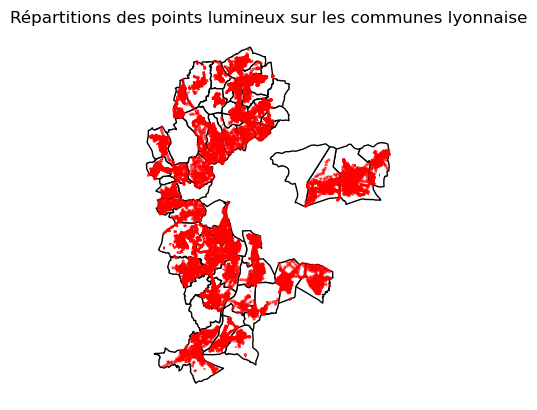

In [41]:

#création du fond de carte
base = com_borders_communes_lyon.plot(color="white", edgecolor="black")
base.set_axis_off()
base.set_title("Répartitions des points lumineux sur les communes lyonnaise")

# Conversion du CRS pour cadrer avec le fond de carte cartiflette
gdf_eclairage_lyon = gdf_eclairage_lyon.to_crs(epsg=4326)


#Intégration de la localisation des caméras de surveillance
gdf_eclairage_lyon.plot(ax=base, color = "red", linewidth=2)

In [43]:
#Le code s'exécute en c. 4' 
# Création d'une carte Folium centrée sur Lyon (on centre sur la place Bellecour)
map_eclairage_lyon = folium.Map(location=[45.7561, 4.8343], zoom_start=12)

# Contours des arrondissements
folium.GeoJson(
    com_borders_communes_lyon,
    name="communes de la région lyonnaise",
    style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5,
    }
).add_to(map_eclairage_lyon)

#Ajout des éclairages
for _, row in gdf_eclairage_lyon.head(100).iterrows():
    tooltip_text = (
        f"Implantation: {row['insee']}<br>type: {row['cablepos']}" 
    )
    coordinates = [(point[1], point[0]) for point in row.geometry.coords]
    # Création de ligne PolyLine
    PolyLine(
        locations=coordinates,
        color='red',
        weight=2,
        opacity=0.8,
        tooltip=tooltip_text
    ).add_to(map_eclairage_lyon)

folium.LayerControl().add_to(map_eclairage_lyon)
    
map_eclairage_lyon.save("carte_videoprotection_lyon.html")
map_eclairage_lyon